In [1]:
from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange

timestep = 1e-4
debug = False
level = 0
seed = 1

fly = CobarFly(
    debug=debug,
    enable_vision=False,
    render_raw_vision=False,
)

if level <= 1:
    arena = levels[level](fly=fly, seed=seed)
else:
    arena = levels[level](fly=fly, timestep=timestep, seed=seed)

cam_params = {"pos": (0, 0, 80)}
timestep = 1e-4

cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

controller = Controller(timestep=timestep)

# run cpg simulation
obs, info = sim.reset()
obs_hist = []
info_hist = []

max_steps = 3000

for i in trange(max_steps):
    # Get observations
    obs, reward, terminated, truncated, info = sim.step(controller.get_actions(obs))
    sim.render()
    if controller.done_level(obs):
        # finish the path integration level
        break

    #if not obs["vision_updated"]:
    if "vision" in obs:
        del obs["vision"]
    if "raw_vision" in obs:
        del obs["raw_vision"]
    obs_hist.append(obs)
    info_hist.append(info)

    if hasattr(controller, "quit") and controller.quit:
        print("Simulation terminated by user.")
        break
    if hasattr(arena, "quit") and arena.quit:
        print("Target reached. Simulation terminated.")
        break

# Save video
save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
save_path.parent.mkdir(parents=True, exist_ok=True)
cam.save_video(save_path, stabilization_time=0)

  0%|          | 0/3000 [00:00<?, ?it/s]


KeyError: 'vision'

[[0.00107015 0.00105766 0.00104082 0.00103742]
 [0.         0.         0.         0.        ]]


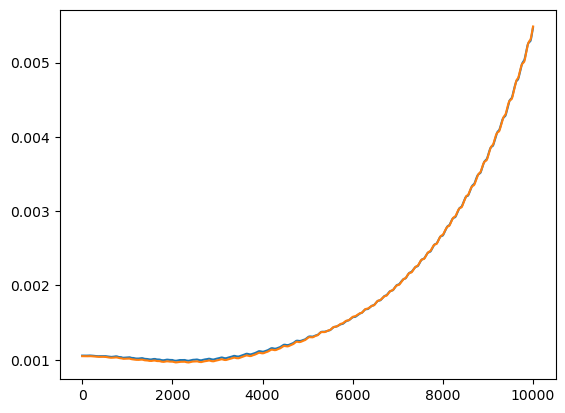

In [2]:
#plot of the odor intensity 
import matplotlib.pyplot as plt
import numpy as np

print(obs_hist[0]["odor_intensity"])    


     
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

plt.plot(odor_left, label="Left Odor Intensity")
plt.plot(odor_right, label="Right Odor Intensity")
